<a href="https://colab.research.google.com/github/SalhaAlzahrani/DiagnosticMLP/blob/main/Ablation_CT_DiagnosticMLP_ChestCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟨 Ablation Study of DiagnosticMLP : CT Image classification - Chest Cancer Dataset


In [ ]:
!pip install nest_asyncio
!pip install -U -q tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math
import nest_asyncio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




---

## 🟡 plot_training_curves

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('bmh') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=10)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

## 🟡 Hyperparameters


In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/CT_Datasets/Computed Tomography (CT) - Chest Cancer/'

image_size = 64 # We'll resize input images to this size.
patch_size = 256
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## 🟡 Dataset


In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 982 files belonging to 4 classes.
Using 884 files for training.
Found 982 files belonging to 4 classes.
Using 98 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
##################
num_classes = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(num_classes): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

['Adenocarcinoma', 'Large cell carcinoma', 'Normal', 'Squamous Cell Carcinoma']


{0: 0.7372372372372372,
 1: 1.387005649717514,
 2: 1.1418604651162791,
 3: 0.9552529182879378}

In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 🟡 Classification model
We implement a method that builds a classifier given the processing blocks.

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

## 🟡 Experiment
We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.F1Score(name='F1 score'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.AUC(name='AUC'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## 🟡 Augmentation


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
    ],
    name="data_augmentation",
)

## 🟡 Patch extraction


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches



---



# ⚛ DiagnosticMLP (proposed model)

In [ ]:
class DiagnosticMLP(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)
        self.mlp3 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        ########################################################################
        # Apply layer normalization.
        x = self.normalize(x)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        ########################################################################
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.mlp3(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        x= x + x_projected
        return x

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks)

In [ ]:
DiagnosticMLP_classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         7         
 ial)                                                            
                                                                 
 patches_1 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_57 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_25 (Sequential)  (None, 64, 256)           973824    
                                                                 
 global_average_pooling1d_1  (None, 256)               0         
  (GlobalAveragePooling1D)                                   



---



## 🔷 Effect of no weighting

In [ ]:
#class_weight=class_weights_dict, #commented at run_experiment
history_DiagnosticMLP = run_experiment(DiagnosticMLP_classifier)

Epoch 1/100


28/28 [==============================] - ETA: 0s - loss: 196.2714 - accuracy: 0.2783 - top5-acc: 1.0000 - Brier score: 337479.8125 - F1 score: 0.2636 - Recall: 0.7489 - Precision: 0.2624 - AUC: 0.5237

28/28 [==============================] - 77s 2s/step - loss: 196.2714 - accuracy: 0.2783 - top5-acc: 1.0000 - Brier score: 337479.8125 - F1 score: 0.2636 - Recall: 0.7489 - Precision: 0.2624 - AUC: 0.5237 - val_loss: 40.6138 - val_accuracy: 0.2653 - val_top5-acc: 1.0000 - val_Brier score: 3234.1633 - val_F1 score: 0.1048 - val_Recall: 0.8571 - val_Precision: 0.2650 - val_AUC: 0.5295 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 61ms/step - loss: 32.2933 - accuracy: 0.2907 - top5-acc: 1.0000 - Brier score: 3628.9912 - F1 score: 0.2812 - Recall: 0.8891 - Precision: 0.2614 - AUC: 0.5249 - val_loss: 22.3479 - val_accuracy: 0.3061 - val_top5-acc: 1.0000 - val_Brier score: 3928.2722 - val_F1 score: 0.1598 - val_Recall: 0.8367 - val_Precision: 0.2733 - val_AUC: 0.5436 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 58ms/step - loss: 23.5688 - accuracy: 0.3292 - top5-acc: 1.0000 - Brier score: 2304.4717 - F1 score: 0.3130 - Recall: 0.8473 - Precision

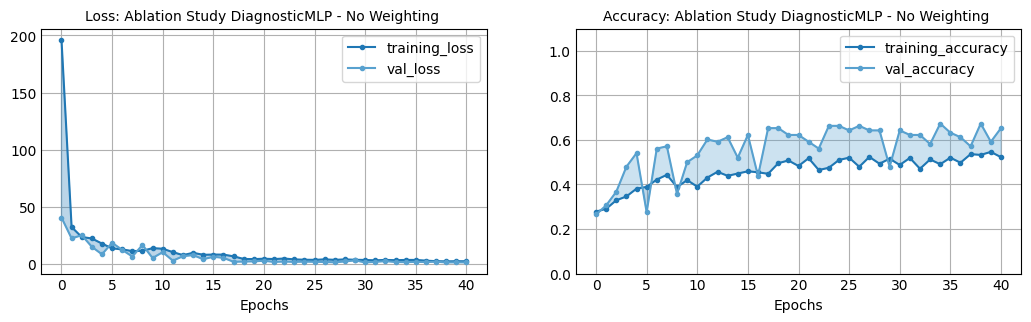

In [ ]:
plot_training_curves(history_DiagnosticMLP, 'Ablation Study DiagnosticMLP - No Weighting ')

In [ ]:
history_DiagnosticMLP_2 = run_experiment(DiagnosticMLP_classifier)

Epoch 1/100


27/28 [===========================>..] - ETA: 0s - loss: 25.5629 - accuracy: 0.3252 - top5-acc: 1.0000 - Brier score: 1507.3408 - F1 score: 0.3243 - Recall: 0.6204 - Precision: 0.3049 - AUC: 0.5767

28/28 [==============================] - 12s 124ms/step - loss: 25.5559 - accuracy: 0.3247 - top5-acc: 1.0000 - Brier score: 1495.3979 - F1 score: 0.3231 - Recall: 0.6222 - Precision: 0.3035 - AUC: 0.5752 - val_loss: 7.6485 - val_accuracy: 0.6122 - val_top5-acc: 1.0000 - val_Brier score: 629.8278 - val_F1 score: 0.4471 - val_Recall: 0.8061 - val_Precision: 0.2992 - val_AUC: 0.5871 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 61ms/step - loss: 11.4524 - accuracy: 0.3914 - top5-acc: 1.0000 - Brier score: 537.4581 - F1 score: 0.3935 - Recall: 0.4536 - Precision: 0.3706 - AUC: 0.6019 - val_loss: 5.0901 - val_accuracy: 0.4796 - val_top5-acc: 1.0000 - val_Brier score: 189.3605 - val_F1 score: 0.4268 - val_Recall: 0.5714 - val_Precision: 0.3836 - val_AUC: 0.6401 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 57ms/step - loss: 9.3265 - accuracy: 0.4016 - top5-acc: 1.0000 - Brier score: 358.8848 - F1 score: 0.4025 - Recall: 0.6120 - Precision: 0.348

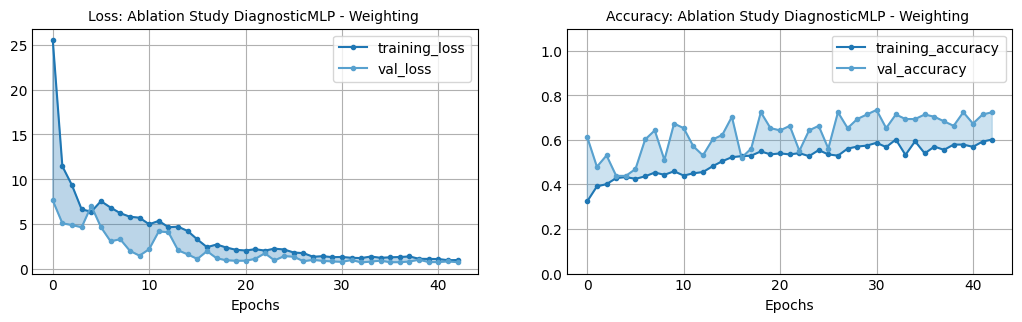

In [ ]:
plot_training_curves(history_DiagnosticMLP_2, 'Ablation Study DiagnosticMLP - Weighting ')



---



## 🔷 Effect of augmentation

In [ ]:
data_augmentation_1 = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name="data_augmentation_1",
)

data_augmentation_2 = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation_2",
)

data_augmentation_3 = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
    ],
    name="data_augmentation_3",
)

data_augmentation_4 = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
        layers.RandomRotation(factor=0.2),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation_4",
)

In [ ]:
def build_classifier(blocks, positional_encoding=False, aug=3):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    if aug == 1:
        augmented = data_augmentation_1(inputs)
    elif aug == 2:
        augmented = data_augmentation_2(inputs)
    elif aug == 3:
        augmented = data_augmentation_3(inputs)
    else :
        augmented = data_augmentation_4(inputs)

    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

Epoch 1/100


27/28 [===========================>..] - ETA: 0s - loss: 229.5551 - accuracy: 0.2488 - top5-acc: 1.0000 - Brier score: 101161.7031 - F1 score: 0.2492 - Recall: 0.6331 - Precision: 0.2453 - AUC: 0.4926

28/28 [==============================] - 12s 113ms/step - loss: 225.1395 - accuracy: 0.2534 - top5-acc: 1.0000 - Brier score: 99012.6094 - F1 score: 0.2534 - Recall: 0.6357 - Precision: 0.2455 - AUC: 0.4929 - val_loss: 48.3227 - val_accuracy: 0.3469 - val_top5-acc: 1.0000 - val_Brier score: 3336.2739 - val_F1 score: 0.2590 - val_Recall: 0.6429 - val_Precision: 0.2158 - val_AUC: 0.4320 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 56ms/step - loss: 22.2169 - accuracy: 0.3586 - top5-acc: 1.0000 - Brier score: 2284.3794 - F1 score: 0.3566 - Recall: 0.8710 - Precision: 0.2612 - AUC: 0.5272 - val_loss: 5.8499 - val_accuracy: 0.5306 - val_top5-acc: 1.0000 - val_Brier score: 1001.1768 - val_F1 score: 0.4789 - val_Recall: 0.9694 - val_Precision: 0.2896 - val_AUC: 0.5893 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 56ms/step - loss: 13.7855 - accuracy: 0.4355 - top5-acc: 1.0000 - Brier score: 1798.2681 - F1 score: 0.4356 - Recall: 0.9389 - Precisio

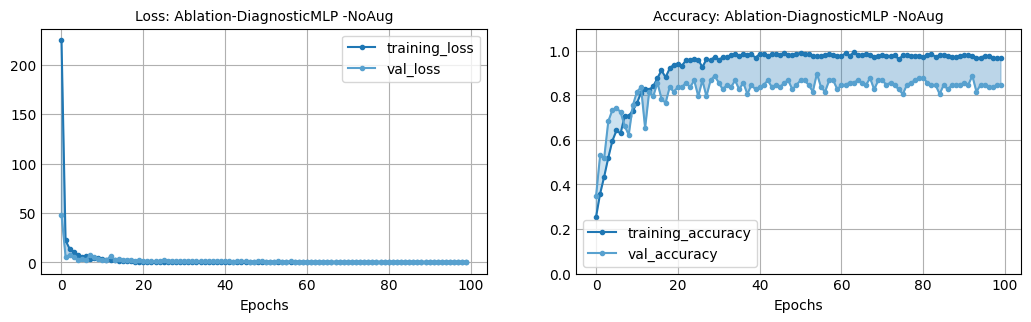

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=1)
history_DiagnosticMLP_NoAug = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_NoAug, 'Ablation-DiagnosticMLP -NoAug')

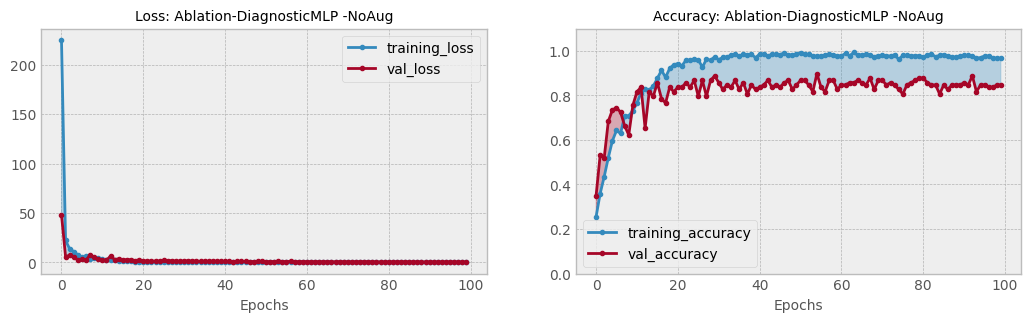

In [ ]:
plot_training_curves(history_DiagnosticMLP_NoAug, 'Ablation-DiagnosticMLP -NoAug')

Epoch 1/100


27/28 [===========================>..] - ETA: 0s - loss: 192.7820 - accuracy: 0.2674 - top5-acc: 1.0000 - Brier score: 106842.5938 - F1 score: 0.2588 - Recall: 0.4977 - Precision: 0.2609 - AUC: 0.5130

28/28 [==============================] - 12s 116ms/step - loss: 189.8770 - accuracy: 0.2658 - top5-acc: 1.0000 - Brier score: 104500.2812 - F1 score: 0.2567 - Recall: 0.4966 - Precision: 0.2604 - AUC: 0.5123 - val_loss: 38.4309 - val_accuracy: 0.2653 - val_top5-acc: 1.0000 - val_Brier score: 1312.4043 - val_F1 score: 0.1057 - val_Recall: 0.4082 - val_Precision: 0.2740 - val_AUC: 0.5236 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 58ms/step - loss: 38.8854 - accuracy: 0.2500 - top5-acc: 1.0000 - Brier score: 2028.0922 - F1 score: 0.2441 - Recall: 0.5769 - Precision: 0.2591 - AUC: 0.5147 - val_loss: 10.1934 - val_accuracy: 0.4796 - val_top5-acc: 1.0000 - val_Brier score: 457.7000 - val_F1 score: 0.3090 - val_Recall: 0.4388 - val_Precision: 0.4526 - val_AUC: 0.6345 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 61ms/step - loss: 21.0645 - accuracy: 0.3100 - top5-acc: 1.0000 - Brier score: 911.2184 - F1 score: 0.3066 - Recall: 0.4333 - Precisio

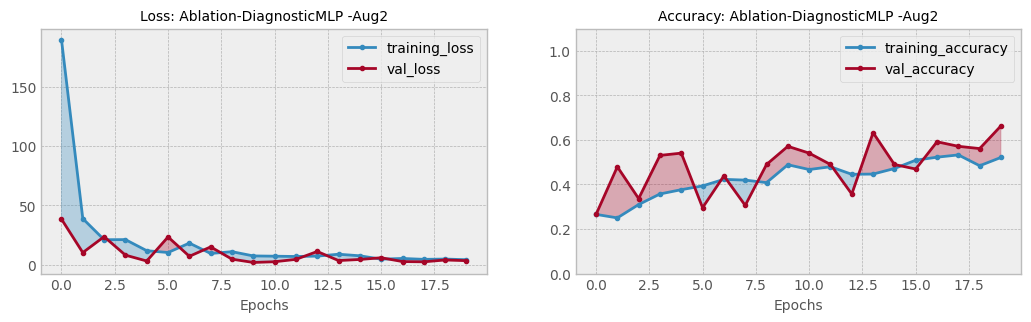

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=2)
history_DiagnosticMLP_Aug2 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_Aug2, 'Ablation-DiagnosticMLP -Aug2')

Epoch 1/100


27/28 [===========================>..] - ETA: 0s - loss: 173.8694 - accuracy: 0.2581 - top5-acc: 1.0000 - Brier score: 60679.2227 - F1 score: 0.2563 - Recall: 0.5081 - Precision: 0.2433 - AUC: 0.4897

28/28 [==============================] - 13s 119ms/step - loss: 170.6067 - accuracy: 0.2602 - top5-acc: 1.0000 - Brier score: 59335.4062 - F1 score: 0.2593 - Recall: 0.5057 - Precision: 0.2436 - AUC: 0.4908 - val_loss: 50.8158 - val_accuracy: 0.1939 - val_top5-acc: 1.0000 - val_Brier score: 1073.4093 - val_F1 score: 0.0819 - val_Recall: 0.1939 - val_Precision: 0.1810 - val_AUC: 0.4493 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 57ms/step - loss: 31.6508 - accuracy: 0.2817 - top5-acc: 1.0000 - Brier score: 1415.9240 - F1 score: 0.2810 - Recall: 0.5995 - Precision: 0.2710 - AUC: 0.5316 - val_loss: 22.6241 - val_accuracy: 0.2449 - val_top5-acc: 1.0000 - val_Brier score: 509.7267 - val_F1 score: 0.1666 - val_Recall: 0.6531 - val_Precision: 0.3333 - val_AUC: 0.6112 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 58ms/step - loss: 17.5653 - accuracy: 0.3631 - top5-acc: 1.0000 - Brier score: 790.9117 - F1 score: 0.3624 - Recall: 0.7240 - Precision

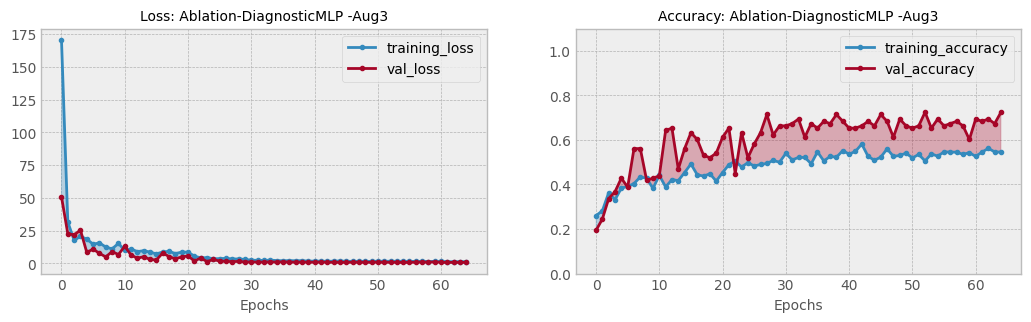

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=3)
history_DiagnosticMLP_Aug3 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_Aug3, 'Ablation-DiagnosticMLP -Aug3')

Epoch 1/100


27/28 [===========================>..] - ETA: 0s - loss: 278.7377 - accuracy: 0.2442 - top5-acc: 1.0000 - Brier score: 392952.2500 - F1 score: 0.2362 - Recall: 0.3206 - Precision: 0.2546 - AUC: 0.5041

28/28 [==============================] - 12s 117ms/step - loss: 273.4305 - accuracy: 0.2500 - top5-acc: 1.0000 - Brier score: 384185.3438 - F1 score: 0.2406 - Recall: 0.3269 - Precision: 0.2564 - AUC: 0.5057 - val_loss: 47.4910 - val_accuracy: 0.3571 - val_top5-acc: 1.0000 - val_Brier score: 3784.8472 - val_F1 score: 0.1316 - val_Recall: 0.5714 - val_Precision: 0.2872 - val_AUC: 0.5493 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 57ms/step - loss: 47.9899 - accuracy: 0.2692 - top5-acc: 1.0000 - Brier score: 3479.5940 - F1 score: 0.2677 - Recall: 0.5611 - Precision: 0.2593 - AUC: 0.5133 - val_loss: 24.8106 - val_accuracy: 0.2449 - val_top5-acc: 1.0000 - val_Brier score: 1120.6007 - val_F1 score: 0.1569 - val_Recall: 0.7143 - val_Precision: 0.2966 - val_AUC: 0.5756 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 61ms/step - loss: 26.1777 - accuracy: 0.2738 - top5-acc: 1.0000 - Brier score: 1326.1071 - F1 score: 0.2712 - Recall: 0.6663 - Precis

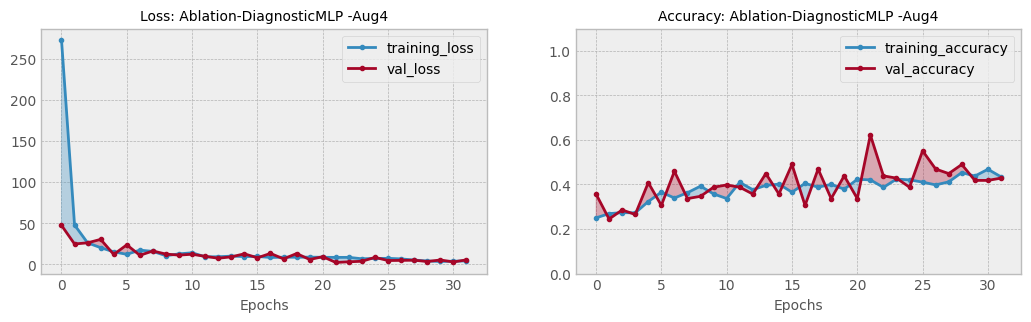

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=4)
history_DiagnosticMLP_Aug4 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_Aug4, 'Ablation-DiagnosticMLP -Aug4')



---



## 🔷 Effect of patches and blocks

Image size: 64 X 64 = 4096
Patch size: 4 X 4 = 16 
Patches per image: 256
Elements per patch (3 channels): 48


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation_3 (Seque  (None, 64, 64, 3)         7         
 ntial)                                                          
                                                                 
 patches (Patches)           (None, 256, 48)           0         
                                                                 
 dense_28 (Dense)            (None, 256, 256)          12544     
                                                                 
 sequential_12 (Sequential)  (None, 256, 256)          2107392   
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                     

28/28 [==============================] - ETA: 0s - loss: 105.2041 - accuracy: 0.2376 - top5-acc: 1.0000 - Brier score: 26924.1758 - F1 score: 0.2333 - Recall: 0.7534 - Precision: 0.2552 - AUC: 0.5117

28/28 [==============================] - 15s 118ms/step - loss: 105.2041 - accuracy: 0.2376 - top5-acc: 1.0000 - Brier score: 26924.1758 - F1 score: 0.2333 - Recall: 0.7534 - Precision: 0.2552 - AUC: 0.5117 - val_loss: 4.6668 - val_accuracy: 0.3367 - val_top5-acc: 1.0000 - val_Brier score: 223.3680 - val_F1 score: 0.2737 - val_Recall: 1.0000 - val_Precision: 0.2649 - val_AUC: 0.5408 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 62ms/step - loss: 14.8140 - accuracy: 0.3032 - top5-acc: 1.0000 - Brier score: 566.5836 - F1 score: 0.3032 - Recall: 0.7353 - Precision: 0.2750 - AUC: 0.5477 - val_loss: 7.6269 - val_accuracy: 0.3673 - val_top5-acc: 1.0000 - val_Brier score: 284.5822 - val_F1 score: 0.2927 - val_Recall: 1.0000 - val_Precision: 0.2857 - val_AUC: 0.5918 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 62ms/step - loss: 11.7736 - accuracy: 0.3529 - top5-acc: 1.0000 - Brier score: 550.5826 - F1 score: 0.3507 - Recall: 0.8314 - Precision: 0.

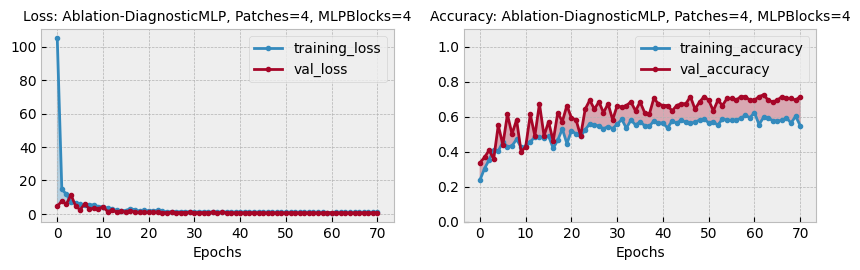

In [ ]:
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=3)
DiagnosticMLP_classifier.summary()
history_DiagnosticMLP_4_4 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_4_4, 'Ablation-DiagnosticMLP, Patches=4, MLPBlocks=4')

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation_3 (Seque  (None, 64, 64, 3)         7         
 ntial)                                                          
                                                                 
 patches_1 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_86 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_37 (Sequential)  (None, 64, 256)           1947648   
                                                                 
 global_average_pooling1d_1  (None, 256)               0         
  (GlobalAveragePooling1D)                                 

28/28 [==============================] - ETA: 0s - loss: 430.3482 - accuracy: 0.2545 - top5-acc: 1.0000 - Brier score: 1069027.7500 - F1 score: 0.2477 - Recall: 0.6097 - Precision: 0.2501 - AUC: 0.4981

28/28 [==============================] - 21s 189ms/step - loss: 430.3482 - accuracy: 0.2545 - top5-acc: 1.0000 - Brier score: 1069027.7500 - F1 score: 0.2477 - Recall: 0.6097 - Precision: 0.2501 - AUC: 0.4981 - val_loss: 69.3509 - val_accuracy: 0.1939 - val_top5-acc: 1.0000 - val_Brier score: 4031.5125 - val_F1 score: 0.1019 - val_Recall: 0.6327 - val_Precision: 0.2385 - val_AUC: 0.4790 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 71ms/step - loss: 56.4020 - accuracy: 0.2602 - top5-acc: 1.0000 - Brier score: 5060.4146 - F1 score: 0.2564 - Recall: 0.5792 - Precision: 0.2537 - AUC: 0.5062 - val_loss: 38.7215 - val_accuracy: 0.1837 - val_top5-acc: 1.0000 - val_Brier score: 2678.0073 - val_F1 score: 0.1357 - val_Recall: 0.7755 - val_Precision: 0.2353 - val_AUC: 0.4696 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 67ms/step - loss: 32.1002 - accuracy: 0.2704 - top5-acc: 1.0000 - Brier score: 3124.3203 - F1 score: 0.2648 - Recall: 0.7794 - Preci

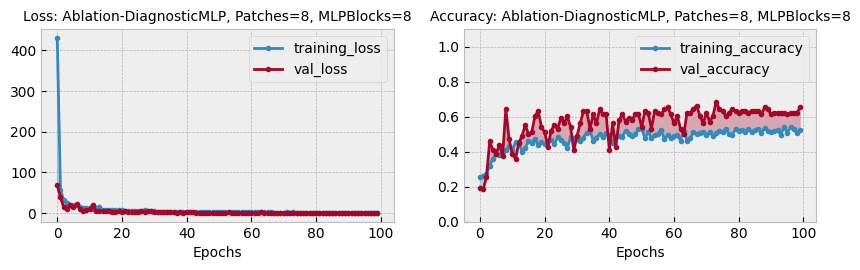

In [ ]:
#
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 8  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=3)
DiagnosticMLP_classifier.summary()
history_DiagnosticMLP_8_8 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_8_8, 'Ablation-DiagnosticMLP, Patches=8, MLPBlocks=8')

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation_3 (Seque  (None, 64, 64, 3)         7         
 ntial)                                                          
                                                                 
 patches_2 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_130 (Dense)           (None, 64, 256)           49408     
                                                                 
 sequential_56 (Sequential)  (None, 64, 256)           1460736   
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                 

27/28 [===========================>..] - ETA: 0s - loss: 284.2191 - accuracy: 0.2488 - top5-acc: 1.0000 - Brier score: 516647.9688 - F1 score: 0.2450 - Recall: 0.6840 - Precision: 0.2564 - AUC: 0.5105

28/28 [==============================] - 16s 150ms/step - loss: 279.6394 - accuracy: 0.2489 - top5-acc: 1.0000 - Brier score: 505170.9688 - F1 score: 0.2447 - Recall: 0.6765 - Precision: 0.2551 - AUC: 0.5082 - val_loss: 83.4588 - val_accuracy: 0.2653 - val_top5-acc: 1.0000 - val_Brier score: 9810.6611 - val_F1 score: 0.1048 - val_Recall: 0.4796 - val_Precision: 0.2249 - val_AUC: 0.4623 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 2s 63ms/step - loss: 48.8463 - accuracy: 0.2738 - top5-acc: 1.0000 - Brier score: 4707.6953 - F1 score: 0.2703 - Recall: 0.7443 - Precision: 0.2535 - AUC: 0.5070 - val_loss: 10.0151 - val_accuracy: 0.4490 - val_top5-acc: 1.0000 - val_Brier score: 2169.9050 - val_F1 score: 0.2764 - val_Recall: 1.0000 - val_Precision: 0.2526 - val_AUC: 0.5068 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 2s 63ms/step - loss: 23.6454 - accuracy: 0.3032 - top5-acc: 1.0000 - Brier score: 2643.1797 - F1 score: 0.2941 - Recall: 0.9095 - Precis

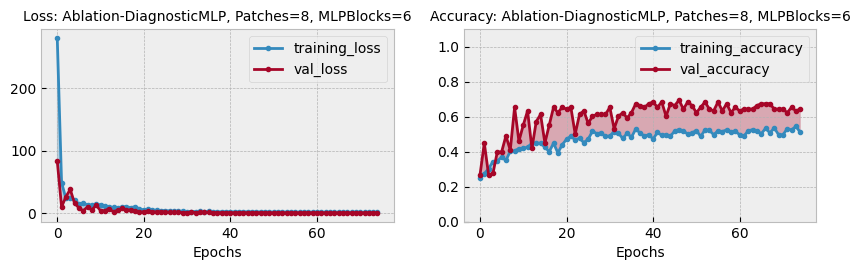

In [ ]:
#
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 6  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks, aug=3)
DiagnosticMLP_classifier.summary()
history_DiagnosticMLP_8_6 = run_experiment(DiagnosticMLP_classifier)
plot_training_curves(history_DiagnosticMLP_8_6, 'Ablation-DiagnosticMLP, Patches=8, MLPBlocks=6')